<font size="+3"><strong>Predicting Apartment Prices</strong></font>

In [2]:
# Import libraries here
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data

## Import

In [3]:
# Build your `wrangle` function
def wrangle(filepath):
    
    df=pd.read_csv(filepath)
      
    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns='place_with_parent_names', inplace=True)
    
    df.drop(columns=['floor', 'expenses', 'rooms', 'price_usd_per_m2', 'surface_total_in_m2'], inplace=True)
    df.drop(columns=['operation', 'property_type', 'properati_url', 'currency'], inplace=True)
    df.drop(columns=['price', 'price_aprox_local_currency', 'price_per_m2'], inplace=True)
    
    return df
    
    
    
    

In [4]:
# Use this cell to test your wrangle function and explore the data
df=wrangle('data/mexico-city-real-estate-1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1101 non-null   float64
 1   surface_covered_in_m2  1101 non-null   float64
 2   lat                    1041 non-null   float64
 3   lon                    1041 non-null   float64
 4   borough                1101 non-null   object 
dtypes: float64(4), object(1)
memory usage: 51.6+ KB


In [6]:
files=glob("data/mexico-city-real-estate-*.csv")
files

['data/mexico-city-real-estate-5.csv',
 'data/mexico-city-real-estate-4.csv',
 'data/mexico-city-real-estate-2.csv',
 'data/mexico-city-real-estate-3.csv',
 'data/mexico-city-real-estate-1.csv']

In [9]:
df_list = [wrangle(file) for file in files]
df = pd.concat(df_list, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,82737.39,75.0,19.362690,-99.150565,Benito Juárez
1,72197.60,62.0,19.291345,-99.124312,Tlalpan
2,44277.72,85.0,19.354987,-99.061709,Iztapalapa
3,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
4,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


## Explore

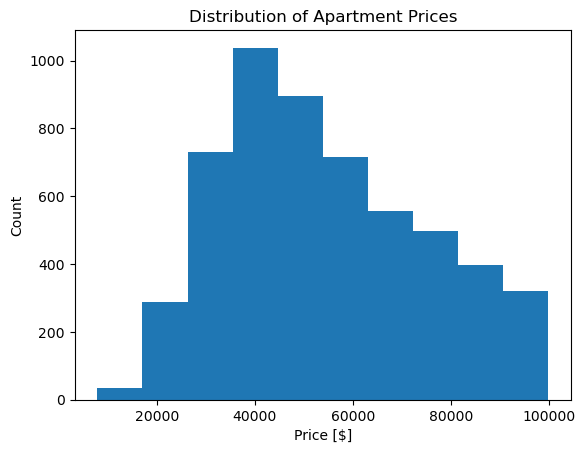

In [11]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices")

# Don't delete the code below 👇
plt.savefig("images/2-5-4.png", dpi=150)


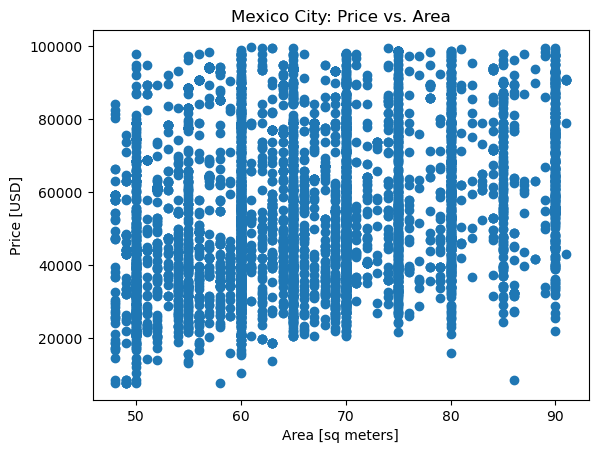

In [13]:
# Build scatter plot
plt.scatter(df['surface_covered_in_m2'], df['price_aprox_usd'])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area")

# Don't delete the code below 👇
plt.savefig("images/2-5-5.png", dpi=150)


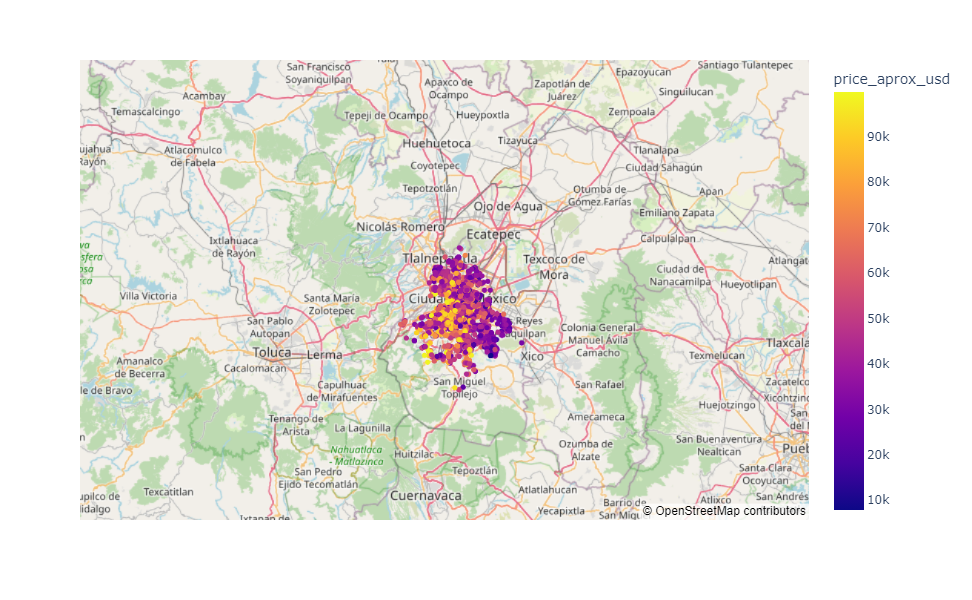

In [16]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
        df,
        lat='lat',
        lon='lon',
        width=600,
        height=600,
        color='price_aprox_usd',
        hover_data=['price_aprox_usd']
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## Split

In [17]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = 'price_aprox_usd'
X_train = df.drop(columns=target)
y_train = df[target]

# Build Model

## Baseline

In [22]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


## Iterate

In [34]:
# Build Model
model = make_pipeline(OneHotEncoder(use_cat_names=True), SimpleImputer(), Ridge())
# Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [39]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60.0,19.493185,-99.205755,Azcapotzalco
1,55.0,19.307247,-99.166700,Coyoacán
2,50.0,19.363469,-99.010141,Iztapalapa
3,60.0,19.474655,-99.189277,Azcapotzalco
4,74.0,19.394628,-99.143842,Benito Juárez


In [46]:
#Training Mean Absolute Error
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

# Communicate Results

In [50]:
coefficients = model["ridge"].coef_
features = model["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients,index=features)
feat_imp

surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito Juárez             13778.188880
borough_Tlalpan                   10319.429804
borough_Iztapalapa               -13349.017448
borough_Gustavo A. Madero         -6637.429757
borough_Venustiano Carranza       -5609.918629
borough_Iztacalco                   405.403127
borough_Coyoacán                   3737.561001
borough_Cuauhtémoc                 -350.531990
borough_Miguel Hidalgo             1977.314718
borough_Azcapotzalco               2459.288646
borough_Tláhuac                  -14166.869486
borough_Álvaro Obregón             3275.121061
borough_La Magdalena Contreras    -5925.666450
borough_Xochimilco                  929.857400
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

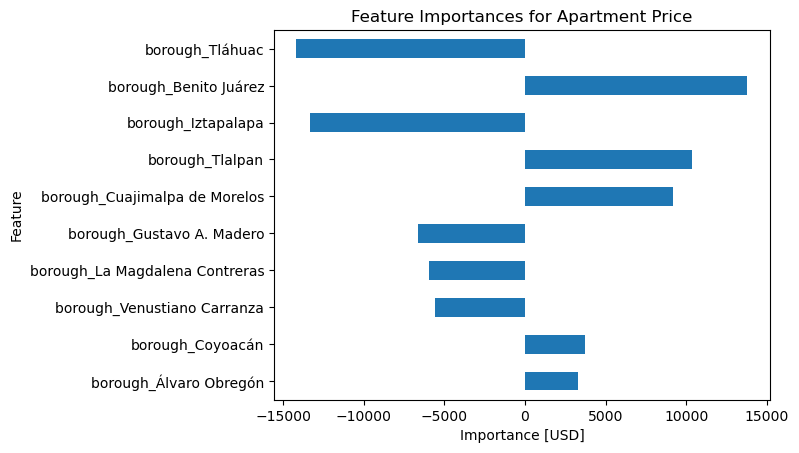

In [71]:
# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")


# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importances for Apartment Price")

# Don't delete the code below 👇
plt.savefig("images/2-5-13.png", dpi=150)
